In [1]:
%matplotlib inline

from __future__ import print_function

import math
import cmath
import re
import os
import glob
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.python.data import Dataset
import seaborn as sns
import tensorflow_hub as hub

tf.logging.set_verbosity(tf.logging.INFO)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

# DEBUGGING AND OUTPUT
PLOT = True
SUMMARIZE = True
TEST = False

# NOTES
NOTES = "mobilenetv2-96"

# Vars
target_label = "label"
id_label = "ImageId"
TYPE = "TLNN"
OUTSTR = "A{:.4f}_Type{}_LR{}_S{}_B{}{}.csv"
if TEST:
    LEARNING_STEPS = 250
    LEARNING_RATE = 0.01
    BATCH_SIZE = 10
else:
    LEARNING_STEPS = 2500
    LEARNING_RATE = 0.01
    BATCH_SIZE = 100

# PATHS
paths = {
    "Training":"/home/wesleytocs/.kaggle/competitions/digit-recognizer/train.csv",
    "Testing":"/home/wesleytocs/.kaggle/competitions/digit-recognizer/test.csv",
    "Submission":"/home/wesleytocs/.kaggle/competitions/digit-recognizer/sample_submission.csv",
}

In [2]:
def adjust_image(data):
    # Reshape to [batch, height, width, channels].
    imgs = tf.reshape(data, [-1, 28, 28, 1])
    # Adjust image size to Inception-v3 input.
    imgs = tf.image.resize_images(imgs, (96, 96))
    # Convert to RGB image.
    imgs = tf.image.grayscale_to_rgb(imgs)
    return imgs

def display(img, w, h):
    one_image = img.reshape(w,h)
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)
    plt.show()

def mobilenet_model_fn(features, labels, mode):
    # Load mobilenet-v2 model.
    module = hub.Module("https://tfhub.dev/google/imagenet/mobilenet_v2_035_96/classification/1")
    input_layer = adjust_image(features["x"])
    outputs = module(input_layer)

    logits = tf.layers.dense(inputs=outputs, units=10)

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    predictions["loss"] = loss

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

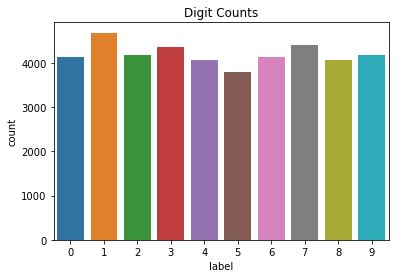

In [3]:
train_data = pd.read_csv(paths["Training"], sep=",").astype(np.int32)
if TEST:
    train_data = train_data.head(1000)
train_data = train_data.reindex(np.random.permutation(train_data.index))
ax = sns.countplot(x="label", data=train_data)
ax.set_title("Digit Counts")
train_labels = np.asarray(train_data.pop(target_label), dtype=np.int32)
train_data = train_data / 255
train_data = np.asarray(train_data, dtype=np.float32)

t_size = int(0.8 * train_data.shape[0])

validation_data = train_data[t_size:]
validation_labels = train_labels[t_size:]
train_data = train_data[:t_size]
train_labels = train_labels[:t_size]

eval_data = pd.read_csv(paths["Testing"], sep=",")
eval_labels = pd.read_csv(paths["Submission"], sep=",")["Label"]
if TEST:
    eval_data = eval_data.head(1000)
    eval_labels = eval_labels.head(1000)
eval_data = eval_data / 255
eval_data = np.asarray(eval_data, dtype=np.float32)
eval_labels = np.asarray(eval_labels, dtype=np.int32)

In [4]:
print("TRAINING")
print(train_data.shape)
print(train_labels.shape)
print("-" * 40)
print("VALIDATION")
print(validation_data.shape)
print(validation_labels.shape)
print("-" * 40)
print("EVALUATION")
print(eval_data.shape)
print(eval_labels.shape)
print(set(eval_labels))

TRAINING
(33600, 784)
(33600,)
----------------------------------------
VALIDATION
(8400, 784)
(8400,)
----------------------------------------
EVALUATION
(28000, 784)
(28000,)
{0}


In [5]:
# Create the Estimator
classifier = tf.estimator.Estimator(
    model_fn=mobilenet_model_fn, model_dir="/tmp/convnet_model")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_num_worker_replicas': 1, '_service': None, '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_steps': None, '_global_id_in_cluster': 0, '_task_type': 'worker', '_evaluation_master': '', '_master': '', '_save_summary_steps': 100, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7feb76a83c88>, '_log_step_count_steps': 100, '_session_config': None, '_train_distribute': None, '_model_dir': '/tmp/convnet_model', '_save_checkpoints_secs': 600, '_tf_random_seed': None, '_num_ps_replicas': 0, '_task_id': 0, '_keep_checkpoint_max': 5, '_is_chief': True}


In [6]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=BATCH_SIZE,
    num_epochs=None,
    shuffle=True)

training_eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    num_epochs=1,
    shuffle=False)

validation_eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": validation_data},
    y=validation_labels,
    num_epochs=1,
    shuffle=False)

In [7]:
# layers = 3
# units = [nearest_2(math.ceil(t_size ** (1/i))) for i in range(2, 2+layers)]
# print(units)
# unitstr = "_".join([str(x) for x in units])

# classifier, accuracy = train_nn_classification_model(
#     learning_rate=LEARNING_RATE,
#     steps=LEARNING_STEPS,
#     hidden_units=units,
#     batch_size=BATCH_SIZE,
#     training_examples=training_examples,
#     training_targets=training_targets,
#     validation_examples=validation_examples,
#     validation_targets=validation_targets)
# print("Final accuracy on validation set: {:.2f}%".format(accuracy * 100))

In [ ]:
logging_hook = tf.train.LoggingTensorHook({"loss" : "loss"}, every_n_iter=10)

In [ ]:
periods = LEARNING_STEPS // 100
steps_per_period = LEARNING_STEPS // periods
t_accs = []
v_accs = []
t_lls = []
v_lls = []
print("Training model...\nMetrics:")
print("\tPERIOD\tTYPE\tTRAIN.\tVALID.")
for period in range(periods):
    classifier.train(
        input_fn=train_input_fn,
        steps=steps_per_period,
        hooks=[logging_hook])
    training_stats = classifier.evaluate(input_fn=training_eval_input_fn)
    validation_stats = classifier.evaluate(input_fn=validation_eval_input_fn)
    t_ll = training_stats["loss"]
    t_acc = 100 * training_stats["accuracy"]
    v_ll = validation_stats["loss"]
    v_acc = 100 * validation_stats["accuracy"]
    print("\t{}\tLgLs\t{:.2f}\t{:.2f}".format(period, t_ll, v_ll))
    print("\t\tAcc.\t{:.2f}%\t{:.2f}%\n".format(t_acc, v_acc))
    t_lls.append(t_ll);
    v_lls.append(v_ll)
    t_accs.append(t_acc)
    v_accs.append(v_acc)
accuracy = classifier.evaluate(input_fn=validation_eval_input_fn)["accuracy"] * 100

Training model...
Metrics:
	PERIOD	TYPE	TRAIN.	VALID.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/var

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchN

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

In [ ]:
print("Final accuracy (on validation data): {:.4f}%".format(accuracy))

# Output a graph of loss metrics over periods.
plt.ylabel("LogLoss")
plt.xlabel("Periods")
plt.title("LogLoss vs. Periods")
plt.plot(t_lls, label="training")
plt.plot(v_lls, label="validation")
plt.legend()
plt.show()

# Output a graph of accuracy over periods.
plt.ylabel("Accuracy")
plt.xlabel("Periods")
plt.title("Accuracy vs. Periods")
plt.plot(t_accs, label="training")
plt.plot(v_accs, label="validation")
plt.legend()
plt.show()

In [ ]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)
stats = classifier.evaluate(input_fn=eval_input_fn)
t_accuracy = 100 * stats["accuracy"]
print("Accuracy on evaluation data (expected ~10%): {:.2f}%".format(t_accuracy))

In [ ]:
# Make Predictions and output the results
predictions = np.array([item['classes'] for item in classifier.predict(input_fn=eval_input_fn)])
ids = np.array([i + 1 for i in range(len(predictions))])
output = pd.DataFrame({id_label:ids, target_label:predictions}, dtype=np.int32)

In [ ]:
name = OUTSTR.format(accuracy, TYPE, LEARNING_RATE, LEARNING_STEPS, BATCH_SIZE,"_" + NOTES if NOTES else "")
print("Filename: '{}'".format(name))
if not TEST:
    output.to_csv(name, index=False)